# 3. Significance Testing for Continuous Metrics (Frequestist Approach)

You have now proven to your stakeholders that including the retro imagery of Keanu has had a positive impact on click-throughs, but they now want to know that the change isn't going to have an impact on content consumption after the user has clicked on the image. In this instance you may want to assess the performance of a continuous, non-discrete variable for each of your experimental conditions. If you are working with a continuous metric — which are variables that can take on an unlimited range of values between both the lowest and highest points of a given measurement — the T-test is probably most familiar to you and that is what this notebook will entail, computation of a parametric statistical test for a page views per session (Pvs_per_session) metric. Internal stakeholders have identified that they would like this metric to either increase or not be negatively impacted by the change.

So let's get to work.

First import the necessary packages for analysis:

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib as plt
import numpy as np
import statistics
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import warnings
import statistics
import scipy
from scipy import stats

In [50]:
warnings.filterwarnings("ignore")

Import your browser level data (each row will represent a unique id or cookie id):

In [52]:
local = 'keanu_df.xlsx'
df = pd.read_excel(local)
df.head(100)

,unique_cookie_id,Variant,Pvs_per_session
0,##kdjdsvbnkdf,Control_Matrix,2.343523
1,kldvnlkaefv,Control_Matrix,1.234300
2,nvaljkdfnvkld4798,Control_Matrix,3.353000
3,shanuf9v354###nkas,Control_Matrix,3.319751
4,nbncjkbd,Control_Matrix,3.824490
...,...,...,...
95,dkvhjdk844,Control_Matrix,8.367136
96,sjhkjfhbdwjkv,Control_Matrix,8.871875
97,kldvnlkaefv,Control_Matrix,9.376613
98,nvaljkdfnvkld4805,Control_Matrix,9.881352


You may want to group by count to ensure you have equally weighted experimental groups, in order to ascertain you have grouped/collected the data correctly:

In [54]:
df.groupby(['Variant']).count()

,unique_cookie_id,Pvs_per_session
Variant,,
Control_Matrix,99,99
Variant_BT,100,100


You can now check the overall mean values for the Pvs_per_session metric:

In [57]:
df.groupby(['Variant']).mean()

,Pvs_per_session
Variant,
Control_Matrix,5.726181
Variant_BT,7.670531


Before we perform any statistical analysis, it is import to check the variance within our data and if this varies for each experimental condition. First we calculate the standard deviation for each variation and then plot the distributions for Pvs_per_session:

Standard deviation of experiment metric for control is is 2.4498
Standard deviation of experiment metric for variant is is 3.2979


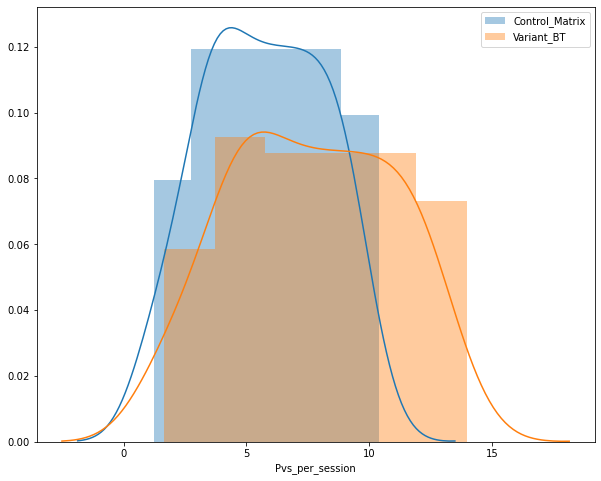

In [73]:
## Create seperate data-frames for experimental conditions

Control_Matrix = df[(df['Variant'] == 'Control_Matrix')]
Variant_BT = df[(df['Variant'] == 'Variant_BT')]

## Calculate individual variance

std_control = statistics.stdev(Control_Matrix.Pvs_per_session)
std_variant = statistics.stdev(Variant_BT.Pvs_per_session)

## Print values

print ("Standard deviation of experiment metric for control is is % s"
    % round(std_control,4))

print ("Standard deviation of experiment metric for variant is is % s"
    % round(std_variant,4))

## Plot distributions

plt.figure(figsize=(10,8))
sb.distplot(Control_Matrix.Pvs_per_session)
sb.distplot(Variant_BT.Pvs_per_session)
plt.legend(labels=['Control_Matrix','Variant_BT'])

As seen above the data for our variant condition exhibits a higher standard deviation, which again is visible in our distributions. The variant Pvs_per_session data exhibits a flatter curve which covers more data points. We can now run a [Kolmogorov–Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test), using the stats package in order to check the Pvs_per_session data isn't abnormally distributed. Here we are looking for a p value > 0.05 to signify our data is not significantly abnormally distributed:

In [104]:
ks_test = stats.kstest(df.Pvs_per_session, 'norm')
p_value_vs = ks_test.pvalue

if p_value_vs < 0.05:
    print("Data is abnormally distributed. Proceed to removing outliers. The p value is",(p_value_vs),)
else:
    print("Data is not abnormally distributed and does not need cleaning.The p value is",(p_value_vs),)

Data is abnormally distributed. Proceed to removing outliers. The p value is 1.968100411302251e-230


As seen above p < 0.05, therefore we will look to cleaning our data and omitting extreme outliers prior to statistical analysis.

## Cleaning data - Remove Outliers

Here we will look to remove data + 3 standard deviations from the mean for Pvs_per_session; this is a scientific standard and alligns with stats engines from numerous online A/B testing platforms. First identify the standard deviation for Pvs_per_session:

In [35]:
std = statistics.stdev(df.Pvs_per_session)
print ("Standard deviation of experiment metric is % s"
    % round(std,4))

Standard deviation of experiment metric is 3.0591


Identify data > 3 standard deviations:

In [105]:
outliers = 3 * std

print("Remove data from data-frame that is % s above the mean of the data"
     % round(outliers,4))

Remove data from data-frame that is 9.1774 above the mean of the data


New data-frame that omits this range and look at new computed means:

In [108]:
df_filtered = df[(df['Pvs_per_session'] <  outliers)]
df_filtered.groupby(['Variant']).mean()

,Pvs_per_session
Variant,
Control_Matrix,5.338705
Variant_BT,5.465452


## Significance testing

We can now perform our parametric statistical test. The code below will execute an analysis of variance (ANOVA) test, although ANOVA can handle multiple independent variables/groups, the individual test performed between each group will be a t.test, which is the most widely recognised assessment for significance testing using a frequentist framework: 

In [115]:
mc = MultiComparison(df_filtered['Pvs_per_session'], df_filtered['Variant'])
mc_results = mc.tukeyhsd()
null_hypothesis = mc_results.reject

print(mc_results)
print("Reject null hypothesis and significant difference between experimental groups:",null_hypothesis,)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
    group1       group2   meandiff p-adj  lower  upper  reject
--------------------------------------------------------------
Control_Matrix Variant_BT   0.1267 0.7328 -0.577 0.8305  False
--------------------------------------------------------------
Reject null hypothesis and significant difference between experimental groups: [False]


As seen above, the results from this experiment are statistically non-significanct we have failed to reject our null hypothesis (that no difference exists between independent groups). Which means you can confidently tell your stakeholders that they needn't worry about the impact on Pvs_per_session by introducing the new widget. It may have increased clicks, but failed to move the needle for our consumption metric. Below, we will look at some useful and user-friendly visualisations that you can present to stakeholders.

## Visualisations

Prior to plotting data, we are going to get it in a format that makes visualisations easy to interpret. This process involves taking samples (1500) from our Pvs_per_session data for each of our experimental conditions and plotting the distribution of all of the samples. As governed by the central limit this means data will follow a normal/bell-shaped distribution with a sample mean that reflects the overall mean of the data. This is useful for visualisations as there will be no heavy skews/tails in the data whilst still maintaining the mean values for the overall mean of each experimental condition:

In [118]:
# Take random samples from each experimental condition in order to transform to normal distribution to plot distributions

results = [] # create an empty list into which I insert the sampled means
random_state = np.arange(0,1500) # random seeds for reproducibility


# Sample with replacement using 50% of the data; do this 1000 times and append the mean seeling time to the list ‘results’


for i in range(1500):
 sample = df_filtered.sample(frac=0.5, replace=True, random_state=random_state[i]).groupby(by='Variant')['Pvs_per_session'].mean()
 results.append(sample)
dist_samples = pd.DataFrame(results)
dist_samples.head(100)

Variant,Control_Matrix,Variant_BT
Pvs_per_session,5.473302,5.431049
Pvs_per_session,5.379704,5.179581
Pvs_per_session,4.862050,5.835279
Pvs_per_session,4.812345,5.872011
Pvs_per_session,5.554773,5.815304
...,...,...
Pvs_per_session,5.149591,5.641678
Pvs_per_session,5.116711,5.972609
Pvs_per_session,5.587683,5.571162
Pvs_per_session,5.536254,5.866078


Plot sampled means in boxplot for experimentation metric:

Variant
Control_Matrix    5.338705
Variant_BT        5.465452
Name: Pvs_per_session, dtype: float64


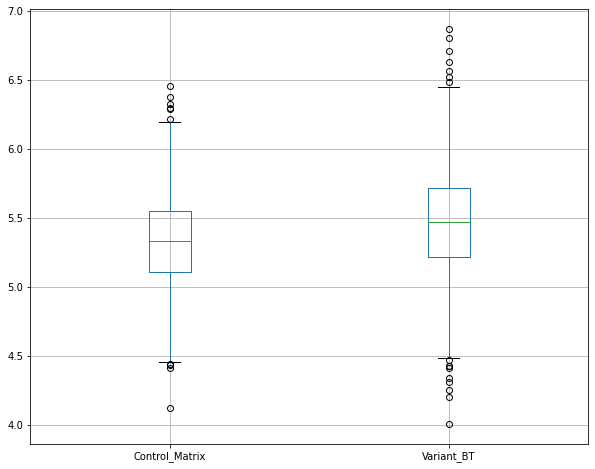

In [120]:
plt.figure(figsize=(10,8))
dist_samples.boxplot(column=['Control_Matrix', 
                                       'Variant_BT'])

filtered = df_filtered.groupby(['Variant']).mean()
filtered = filtered['Pvs_per_session']
print(filtered)

Plot sampled means for metric in distribution plot:

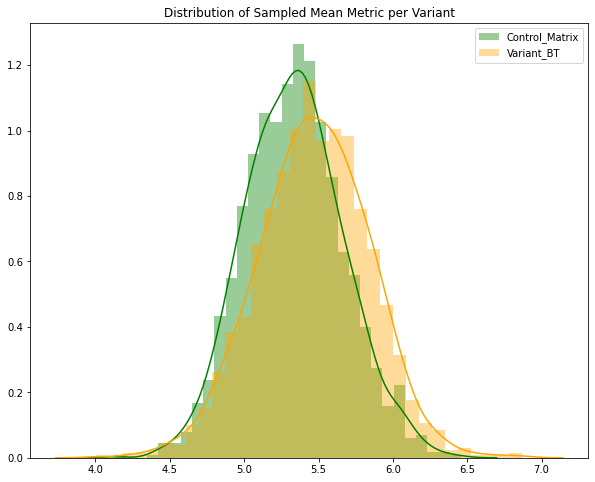

In [121]:
plt.figure(figsize=(10,8))
sb.distplot(dist_samples[['Control_Matrix']], hist=True, color='green')
sb.distplot(dist_samples[['Variant_BT']], hist=True, color='orange')
plt.legend(labels=['Control_Matrix','Variant_BT'])
plt.title("Distribution of Sampled Mean Metric per Variant")
plt.show()

These are some useful visualisations you can utilise to show the overlap of the data to identify the lack of difference between groups. In the next chapter we will look to perform the same analysis, but returning to our good old Bayesian estimations.